# Notebook for Evaluaing Sudoku Model 

In [1]:
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import csv
import math
import numpy as np
import functools
import random, copy
import urllib.request
import zipfile


import sys 
sys.path.append("../")
from ddsm import *

In [5]:
print(np.version.version)

1.22.4


Let's load presampled noise 

In [3]:
#v_one, v_zero, v_one_loggrad, v_zero_loggrad, timepoints = torch.load('steps400.cat9.time1.0.samples100000.pth')
v_one, v_zero, v_one_loggrad, v_zero_loggrad, timepoints = torch.load('steps400.cat9.time1.0.samples50000.pth')
torch.set_default_dtype(torch.float32)


Let's plot it 

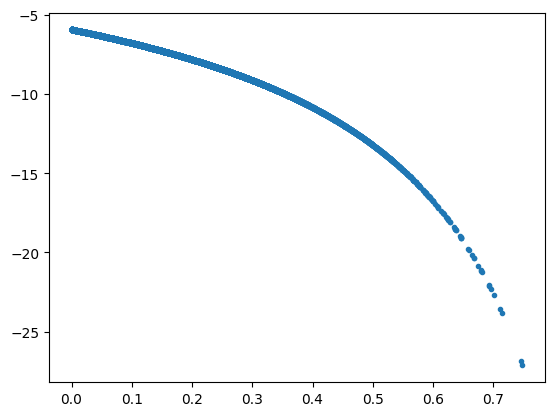

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(v_one[:,-1,0].detach().cpu(), v_one_loggrad[:,-1,0].detach().cpu(),'.')

We define several functions

In [5]:
def construct_puzzle_solution():
    """
    Randomly arrange numbers in a grid while making all rows, columns and
    squares (sub-grids) contain the numbers 1 through 9.
    For example, "sample" (above) could be the output of this function.
    """
    
    # Loop until we're able to fill all 81 cells with numbers, while
    # satisfying the constraints above.
    while True:
        try:
            puzzle  = [[0]*9 for i in range(9)] # start with blank puzzle
            rows    = [set(range(1,10)) for i in range(9)] # set of available
            columns = [set(range(1,10)) for i in range(9)] #   numbers for each
            squares = [set(range(1,10)) for i in range(9)] #   row, column and square
            for i in range(9):
                for j in range(9):
                    # pick a number for cell (i,j) from the set of remaining available numbers
                    choices = rows[i].intersection(columns[j]).intersection(squares[(i//3)*3 + j//3])
                    choice  = random.choice(list(choices))
        
                    puzzle[i][j] = choice
        
                    rows[i].discard(choice)
                    columns[j].discard(choice)
                    squares[(i//3)*3 + j//3].discard(choice)

            # success! every cell is filled.
            return puzzle
            
        except IndexError:
            # if there is an IndexError, we have worked ourselves in a corner (we just start over)
            pass

def pluck(puzzle, n=0):

    """
    Randomly pluck out cells (numbers) from the solved puzzle grid, ensuring that any
    plucked number can still be deduced from the remaining cells.
    For deduction to be possible, each other cell in the plucked number's row, column,
    or square must not be able to contain that number.

    Answers the question: can the cell (i,j) in the puzzle "puz" contain the number
    in cell "c"? """
    def canBeA(puz, i, j, c):
        v = puz[c//9][c%9]
        if puz[i][j] == v: return True
        if puz[i][j] in range(1,10): return False
            
        for m in range(9): # test row, col, square
            # if not the cell itself, and the mth cell of the group contains the value v, then "no"
            if not (m==c//9 and j==c%9) and puz[m][j] == v: return False
            if not (i==c//9 and m==c%9) and puz[i][m] == v: return False
            if not ((i//3)*3 + m//3==c//9 and (j//3)*3 + m%3==c%9) and puz[(i//3)*3 + m//3][(j//3)*3 + m%3] == v:
                return False

        return True


    """
    starts with a set of all 81 cells, and tries to remove one (randomly) at a time
    but not before checking that the cell can still be deduced from the remaining cells. """
    cells     = set(range(81))
    cellsleft = cells.copy()
    while len(cells) > n and len(cellsleft):
        cell = random.choice(list(cellsleft)) # choose a cell from ones we haven't tried
        cellsleft.discard(cell) # record that we are trying this cell

        # row, col and square record whether another cell in those groups could also take
        # on the value we are trying to pluck. (If another cell can, then we can't use the
        # group to deduce this value.) If all three groups are True, then we cannot pluck
        # this cell and must try another one.
        row = col = square = False

        for i in range(9):
            if i != cell//9:
                if canBeA(puzzle, i, cell%9, cell): row = True
            if i != cell%9:
                if canBeA(puzzle, cell//9, i, cell): col = True
            if not (((cell//9)//3)*3 + i//3 == cell//9 and ((cell//9)%3)*3 + i%3 == cell%9):
                if canBeA(puzzle, ((cell//9)//3)*3 + i//3, ((cell//9)%3)*3 + i%3, cell): square = True

        if row and col and square:
            continue # could not pluck this cell, try again.
        else:
            # this is a pluckable cell!
            puzzle[cell//9][cell%9] = 0 # 0 denotes a blank cell
            cells.discard(cell) # remove from the set of visible cells (pluck it)
            # we don't need to reset "cellsleft" because if a cell was not pluckable
            # earlier, then it will still not be pluckable now (with less information
            # on the board).

    # This is the puzzle we found, in all its glory.
    return (puzzle, len(cells))
    
    
"""
That's it.
If we want to make a puzzle we can do this:
    pluck(construct_puzzle_solution())
    
The following functions are convenience functions for doing just that...
"""



"""
This uses the above functions to create a new puzzle. It attempts to
create one with 28 (by default) given cells, but if it can't, it returns
one with as few givens as it is able to find.
This function actually tries making 100 puzzles (by default) and returns
all of them. The "best" function that follows this one selects the best
one of those.
"""
def run(n = 28, iter=100):
    all_results = {}
#     print "Constructing a sudoku puzzle."
#     print "* creating the solution..."
    a_puzzle_solution = construct_puzzle_solution()
    
#     print "* constructing a puzzle..."
    for i in range(iter):
        puzzle = copy.deepcopy(a_puzzle_solution)
        (result, number_of_cells) = pluck(puzzle, n)
        all_results.setdefault(number_of_cells, []).append(result)
        if number_of_cells <= n: break
 
    return all_results, a_puzzle_solution

def best(set_of_puzzles):
    # Could run some evaluation function here. For now just pick
    # the one with the fewest "givens".
    return set_of_puzzles[min(set_of_puzzles.keys())][0]

def display(puzzle):
    for row in puzzle:
        print(' '.join([str(n or '_') for n in row]))

    


def gen_sudoku(num):
    '''
    Generates `num` games of Sudoku.
    '''
    solutions = np.zeros((num, 9, 9), np.int32)
    for i in range(num):
        solutions[i] = construct_puzzle_solution()

    return solutions


In [6]:
def construct_puzzle_solution_successrate(total_success):
    # Loop until we're able to fill all 81 cells with numbers, while
    # satisfying the constraints above.
    nfailure=0
    nsuccess=0
    while nsuccess<total_success:
        try:
            puzzle  = [[0]*9 for i in range(9)] # start with blank puzzle
            rows    = [set(range(1,10)) for i in range(9)] # set of available
            columns = [set(range(1,10)) for i in range(9)] #   numbers for each
            squares = [set(range(1,10)) for i in range(9)] #   row, column and square
            for i in range(9):
                for j in range(9):
                    # pick a number for cell (i,j) from the set of remaining available numbers
                    choices = rows[i].intersection(columns[j]).intersection(squares[(i//3)*3 + j//3])
                    choice  = random.choice(list(choices))
        
                    puzzle[i][j] = choice
        
                    rows[i].discard(choice)
                    columns[j].discard(choice)
                    squares[(i//3)*3 + j//3].discard(choice)

            # success! every cell is filled.
            nsuccess += 1
            
        except IndexError:
            print('fail')
            nfailure += 1
            pass
    return nsuccess / nfailure
#construct_puzzle_solution(10000)

In [7]:
#check sudoku correctness
def sudoku_acc(sample, return_array=False):
    sample = sample.detach().cpu().numpy()
    correct = 0
    total = sample.shape[0]
    ans = sample.argmax(-1)+1
    numbers_1_N = np.arange(1, 9 + 1)
    corrects = []
    for board in ans:
        if (np.all(np.sort(board, axis=1) == numbers_1_N) and
            np.all(np.sort(board.T, axis=1) == numbers_1_N)):
            # Check blocks
            
            blocks = board.reshape(3, 3, 3, 3).transpose(0, 2, 1, 3).reshape(9, 9)
            if np.all(np.sort(board.T, axis=1) == numbers_1_N):
                correct += 1
                corrects.append(True)
            else:
                corrects.append(False)
        else:
            corrects.append(False)

    if return_array:
        return corrects
    else:
        print('correct {} %'.format(100 * correct / total))


In [8]:
colind = np.array([[0,1,2,3,4,5,6,7,8],
            [0,1,2,3,4,5,6,7,8],
            [0,1,2,3,4,5,6,7,8],
            [0,1,2,3,4,5,6,7,8],
            [0,1,2,3,4,5,6,7,8],
            [0,1,2,3,4,5,6,7,8],
            [0,1,2,3,4,5,6,7,8],
            [0,1,2,3,4,5,6,7,8],
            [0,1,2,3,4,5,6,7,8]])

rowind = np.array([[0,0,0,0,0,0,0,0,0],
          [1,1,1,1,1,1,1,1,1],
          [2,2,2,2,2,2,2,2,2],
          [3,3,3,3,3,3,3,3,3],
          [4,4,4,4,4,4,4,4,4],
          [5,5,5,5,5,5,5,5,5],
          [6,6,6,6,6,6,6,6,6],
          [7,7,7,7,7,7,7,7,7],
          [8,8,8,8,8,8,8,8,8]])


blockind = np.array([[0,0,0,1,1,1,2,2,2],
          [0,0,0,1,1,1,2,2,2],
          [0,0,0,1,1,1,2,2,2],
          [3,3,3,4,4,4,5,5,5],
          [3,3,3,4,4,4,5,5,5],
          [3,3,3,4,4,4,5,5,5],
          [6,6,6,7,7,7,8,8,8],
          [6,6,6,7,7,7,8,8,8],
          [6,6,6,7,7,7,8,8,8]])

colenc = np.zeros((81,9))
rowenc = np.zeros((81,9))
blockenc = np.zeros((81,9))
colenc[np.arange(81),colind.flatten()] = 1
rowenc[np.arange(81),rowind.flatten()] = 1
blockenc[np.arange(81),blockind.flatten()] = 1
allenc = np.concatenate([colenc, rowenc, blockenc], axis=1)
allenc_relative = torch.FloatTensor(allenc[:,None,:]==allenc[None,:,:])

In [9]:
#Sudoku dataloader that generate sudoku in real-time
class SudokuDataset(Dataset):
    def __init__(self):
        pass
    def __len__(self):
        return int(batchSize*1000)

    def __getitem__(self, idx):
        sudoku = gen_sudoku(1)
        dataset = np.eye(9)[sudoku.reshape(sudoku.shape[0],-1)-1]
        return dataset



We calculate time dependent weights

In [10]:
#importance sampling weights 
#this part may change, no need to spend too much time on understanding it
device = 'cuda'
batchSize = 256 

def worker_init_fn(worker_id):                                                          
    np.random.seed(worker_id)

sb = UnitStickBreakingTransform()
ds = SudokuDataset()
train_dataloader = DataLoader(ds, batchSize, shuffle=True, num_workers=16, worker_init_fn=worker_init_fn)

time_dependent_cums = torch.zeros(timepoints.shape[0]).to(device)
time_dependent_counts = torch.zeros(timepoints.shape[0]).to(device)

avg_loss = 0.
num_items = 0
for i, x in enumerate(train_dataloader):
    x = x.reshape(-1,9,9,9)
    random_t = torch.randint(0, timepoints.shape[0], (x.shape[0],))
    order = np.random.permutation(np.arange(9))
    #perturbed_x, perturbed_x_grad = diffusion_factory(x[...,order], random_t,  v_one, v_zero,v_one_loggrad, v_zero_loggrad, alpha, beta)
    perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x[...,order], random_t, v_one, v_one_loggrad)
    perturbed_x = perturbed_x[..., np.argsort(order)]
    perturbed_x_grad = perturbed_x_grad[..., np.argsort(order)]
    perturbed_x = perturbed_x.to(device)    
    perturbed_x_grad = perturbed_x_grad.to(device)
    random_t = random_t.to(device)
    perturbed_v = sb._inverse(perturbed_x)

    
    order = np.random.permutation(np.arange(9))
    perturbed_v = sb._inverse(perturbed_x[..., order], prevent_nan=True).detach()

    time_dependent_counts[random_t] += 1
    #time_dependent_cums[random_t] +=  ( ((perturbed_x)*(1-perturbed_x))**2 * (perturbed_x_grad)**2).mean(dim=(1,2,3)).detach()
    time_dependent_cums[random_t] +=  (perturbed_v*(1-perturbed_v) * (gx_to_gv(perturbed_x_grad[...,order],perturbed_x[...,order]))**2).mean(dim=(1,2,3)).detach()
    time_dependent_weights =  time_dependent_cums / time_dependent_counts
    time_dependent_weights = time_dependent_weights / time_dependent_weights.mean()
    
    if i > 20:
        break

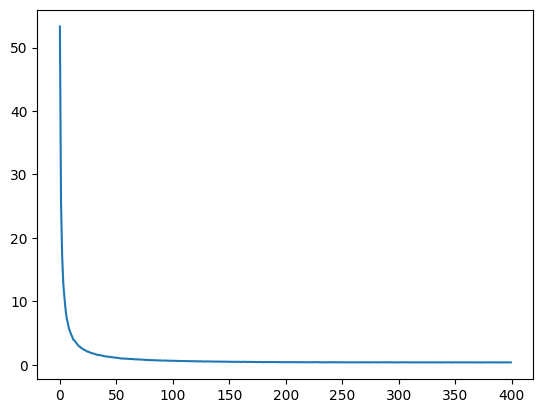

In [11]:
plt.plot(time_dependent_weights.cpu())

Let's define a model

In [12]:
#modified from minGPT 
# -----------------------------------------------------------------------------

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, n_embd, n_head, bias=None):
        super().__init__()
        assert n_embd % n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)

        self.n_head = n_head
        self.n_embd = n_embd
        self.register_buffer("bias",bias)
        
        self.bias_proj = nn.Linear(bias.shape[-1], n_head) #T, T, nh

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att + self.bias_proj(self.bias).permute((2,0,1))
        att = F.softmax(att, dim=-1)
        #att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, n_embd, n_head, bias=None):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = SelfAttention(n_embd, n_head, bias=bias)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(n_embd, 4 * n_embd),
            c_proj  = nn.Linear(4 * n_embd, n_embd),
            act     = NewGELU(),
        ))
        m = self.mlp

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp.c_proj(self.mlp.act(self.mlp.c_fc(self.ln_2(x))))
        return x
    

class GaussianFourierProjection(nn.Module):

    """
    Gaussian random features for encoding time steps.
    """  
    
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    
    """
    A fully connected layer that reshapes outputs to feature maps.
    """
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[...]

    
class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, allenc_rel, embed_dim=256, ):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    
    self.linear = Dense(9,128)
    self.blocks = nn.ModuleList(Block(128, 8, bias=allenc_rel) for _ in range(20))
    self.denses = nn.ModuleList(Dense(embed_dim, 128) for _ in range(20))
    self.act = NewGELU()
    self.softplus = nn.Softplus()
    self.output = Dense(128,9)
    self.scale = nn.Parameter(torch.ones(1))

  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))
    
    # Encoding path
    h =   self.linear(x.view(-1,81,9))
    for le, ld in zip(self.blocks, self.denses):
        h = le(h + ld(embed)[:,None,:])

    h = self.output(h)

    #h = h.reshape(x.size()) * torch.exp(-t[:,None,None,None]* self.softplus(self.scale)) /  ((x+1e-6)*(1-x+1e-6))
    h = h.reshape(x.size()) #* torch.exp(-t[:,None,None,None]* self.softplus(self.scale)) * (1/(x+1e-3)+1/(1-x+1e-3))
    h = h - h.mean(axis=-1, keepdims=True)
    return h

## Evaluation of the Best Model

In [13]:
score_model = nn.DataParallel(ScoreNet(allenc_relative))
score_model.module.load_state_dict(torch.load('../best_model_weights/sudoku/sudoku.transformer.pth'))
score_model = score_model.to('cuda')
score_model.eval()


DataParallel(
  (module): ScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (linear): Dense(
      (dense): Linear(in_features=9, out_features=128, bias=True)
    )
    (blocks): ModuleList(
      (0-19): 20 x Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=True)
          (c_proj): Linear(in_features=128, out_features=128, bias=True)
          (bias_proj): Linear(in_features=27, out_features=8, bias=True)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (act): NewGELU()
        )
      )
    )
    (denses): ModuleList(
      (0-19): 20 x Dense(
        (de

In [14]:
device='cuda'
score_model.eval()
acc = []
samples = Euler_Maruyama_sampler(score_model,
                  (9,9,9), 
                  batch_size=256,
                  max_time=1, 
                  min_time=0.01,
                  time_dilation=8,
                  num_steps=100,
                  random_order=False,
                  speed_balanced=False,
                  device=device)
acc.append(sudoku_acc(samples))

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:59<00:00, 13.38it/s]

correct 100.0 %


## Generation Task
Generate results for table 2 - Sudoku Generation

In [15]:
for time_dilation in [1, 2, 4, 8]:
    acc = []
    for i in range(10):
        score_model.eval()
        samples = Euler_Maruyama_sampler(score_model,
                          (9,9,9),
                          batch_size=256,
                          max_time=1,
                          min_time=0.01,
                          time_dilation=time_dilation,
                          num_steps=100,
                          random_order=False,
                          speed_balanced=True,
                          speed_factor=9./2., 
                          device=device)
        acc.append(np.mean(sudoku_acc(samples, return_array=True)))
    print(np.mean(acc), np.std(acc)/np.sqrt(9))

100%|██████████| 100/100 [00:06<00:00, 15.83it/s]


0.93828125 0.004934191489973024


100%|██████████| 200/200 [00:12<00:00, 15.72it/s]


0.99296875 0.001135129933213717


100%|██████████| 400/400 [00:25<00:00, 15.64it/s]


0.99921875 0.0005208333333333333


100%|██████████| 800/800 [00:50<00:00, 15.70it/s]

1.0 0.0


In [16]:
# 0.951171875 0.003917085665752949
# 0.992578125 0.001589395262465326
# 0.99921875 0.0007812500000000002
# 0.99921875 0.0005208333333333333

## Solving SatNet Puzzles

In [17]:
#satnet puzzles
sat_puzzles = torch.load('../data/satnet_sudoku/features.pt').argmax(-1) + 1
sat_puzzles[torch.load('../data/satnet_sudoku/features.pt').sum(-1)==0]=0

masks = torch.FloatTensor(np.vstack([np.zeros(9)*np.nan,np.eye(9)])[sat_puzzles]).cuda()

In [18]:
sampler = Euler_Maruyama_sampler

Let's check that we can solve Sudoku with any number of attempts

In [19]:
#hard puzzles that are not solved in one run can be solved in multiple runs
def rep8(sudoku0, repeat=1):
    #generate symmetric sudokus
    sudoku1 = sudoku0[...,::-1,:]
    sudoku2 = sudoku0.transpose(0,2,1,3)
    sudoku3 = sudoku0[...,::-1,:].transpose(0,2,1,3)
    sudoku4 = sudoku0[:,::-1,:,:]
    sudoku5 = sudoku0[:,::-1,:,:].transpose(0,2,1,3)
    sudoku6 = sudoku0[...,::-1,:][:,::-1,:,:]
    sudoku7 = sudoku0[...,::-1,:][:,::-1,:,:].transpose(0,2,1,3)
    sudoku = np.concatenate([sudoku0, sudoku1,sudoku2,sudoku3,sudoku4,sudoku5,sudoku6,sudoku7], axis=0)
    sudoku = np.repeat(sudoku, repeat, axis=0)
    return sudoku

solutions = []
ntrys = []
for i, q in enumerate(np.array_split(masks, masks.shape[0] // 128)):
    mask = q
    solution = np.zeros((mask.shape[0], 9, 9))

    istrue = np.ones(mask.shape[0])==0
    ntry = np.zeros(mask.shape[0])

    while True:
        batchsize = 512
        n_rep = batchsize // np.sum(~istrue)
        
        samples = sampler(score_model,
                            (9,9,9),
                            mask=torch.FloatTensor(np.repeat(mask.cpu().numpy()[~istrue,:], n_rep, axis=0)).cuda(),
                            batch_size=np.sum(~istrue) * n_rep,
                            max_time=1,
                            min_time=0.01,
                            time_dilation=8,
                            num_steps=100,
                            random_order=False,
                            speed_balanced=True,
                            speed_factor=9./2.,
                            device=device)
        
        acc = np.array(sudoku_acc(samples, return_array=True)).reshape((-1,n_rep))
        
        istrueinds = np.where(~istrue)[0]
        for i in range(acc.shape[0]):
            if acc[i,:].any():
                ind = i * n_rep + np.where(acc[i,:])[0][0]
                solution[np.where(~istrue)[0][i] - 1] = samples[ind].detach().cpu().numpy().argmax(-1) 
                ntry[istrueinds[i]] = ntry[istrueinds[i]] + np.where(acc[i,:])[0][0] + 1
            else:
                ntry[istrueinds[i]] = ntry[istrueinds[i]] + acc.shape[1]
        istrue[~istrue] =  acc.any(axis=1)

        print('correct {} %'.format(100 * np.mean(istrue)))
        
        if np.all(istrue):
            print('Bingo!')
            break
            
    solutions.append(solution)
    ntrys.append(ntry)
    


100%|██████████| 800/800 [00:54<00:00, 14.78it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.27it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.11it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:51<00:00, 15.58it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.87it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:51<00:00, 15.67it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.37it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.27it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.24it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.81it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.84it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.38it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.34it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.31it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:51<00:00, 15.64it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.05it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.29it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:04<00:00, 12.48it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:07<00:00, 11.92it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:00<00:00, 13.27it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.82it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.83it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:58<00:00, 13.67it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:07<00:00, 11.81it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:07<00:00, 11.88it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.20it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.13it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:06<00:00, 12.11it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:05<00:00, 12.21it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:59<00:00, 13.40it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.94it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.92it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:01<00:00, 12.91it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:01<00:00, 12.98it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:56<00:00, 14.22it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:51<00:00, 15.66it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.37it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:51<00:00, 15.65it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:59<00:00, 13.41it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.91it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:48<00:00, 16.61it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.04it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.23it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:03<00:00, 12.51it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:57<00:00, 13.81it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.88it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.92it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:59<00:00, 13.40it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:04<00:00, 12.37it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:05<00:00, 12.22it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.07it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.13it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:55<00:00, 14.52it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:07<00:00, 11.82it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:07<00:00, 11.87it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:52<00:00, 15.11it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:48<00:00, 16.36it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.30it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:05<00:00, 12.15it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:58<00:00, 13.65it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.96it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:50<00:00, 15.94it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:02<00:00, 12.78it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:02<00:00, 12.79it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.14it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:49<00:00, 16.12it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:55<00:00, 14.37it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:02<00:00, 12.78it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:05<00:00, 12.28it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:53<00:00, 14.96it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [00:59<00:00, 13.42it/s]


correct 100.0 %
Bingo!


100%|██████████| 800/800 [01:05<00:00, 12.24it/s]

correct 100.0 %
Bingo!


In [21]:
print(type(ntrys), len(ntrys))
np.concatenate(ntrys).mean()

<class 'list'> 78


1.0225

Let's reproduce Table 2, Solution task

In [26]:
for time_dilation in [1, 2, 4, 8]:
    acc = []
    for i, mask in enumerate(np.array_split(masks, masks.shape[0] // 128)):
        samples = Euler_Maruyama_sampler(score_model,
                                            (9,9,9),
                                            mask=mask,
                                            batch_size=mask.shape[0],
                                            max_time=1,
                                            min_time=0.01,
                                            time_dilation=time_dilation,
                                            num_steps=100,
                                            random_order=False,
                                            speed_balanced=True,
                                            speed_factor=9./2.,
                                            device=device)
        acc.append(np.mean(sudoku_acc(samples, return_array=True)))
        print(len(acc))

    print(np.mean(acc), np.std(acc)/np.sqrt(9))
    print('summary acc list:', len(acc))

100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


1


100%|██████████| 100/100 [00:05<00:00, 18.15it/s]


2


100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


3


100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


4


100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


5


100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


6


100%|██████████| 100/100 [00:05<00:00, 17.23it/s]


7


100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


8


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


9


100%|██████████| 100/100 [00:05<00:00, 16.89it/s]


10


100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


11


100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


12


100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


13


100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


14


100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


15


100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


16


100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


17


100%|██████████| 100/100 [00:05<00:00, 19.04it/s]


18


100%|██████████| 100/100 [00:05<00:00, 18.15it/s]


19


100%|██████████| 100/100 [00:05<00:00, 18.83it/s]


20


100%|██████████| 100/100 [00:05<00:00, 18.98it/s]


21


100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


22


100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


23


100%|██████████| 100/100 [00:05<00:00, 16.95it/s]


24


100%|██████████| 100/100 [00:06<00:00, 16.53it/s]


25


100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


26


100%|██████████| 100/100 [00:06<00:00, 16.54it/s]


27


100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


28


100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


29


100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


30


100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


31


100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


32


100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


33


100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


34


100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


35


100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


36


100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


37


100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


38


100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


39


100%|██████████| 100/100 [00:06<00:00, 15.77it/s]


40


100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


41


100%|██████████| 100/100 [00:06<00:00, 16.62it/s]


42


100%|██████████| 100/100 [00:06<00:00, 15.76it/s]


43


100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


44


100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


45


100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


46


100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


47


100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


48


100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


49


100%|██████████| 100/100 [00:05<00:00, 16.95it/s]


50


100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


51


100%|██████████| 100/100 [00:05<00:00, 18.72it/s]


52


100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


53


100%|██████████| 100/100 [00:05<00:00, 16.81it/s]


54


100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


55


100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


56


100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


57


100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


58


100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


59


100%|██████████| 100/100 [00:05<00:00, 17.01it/s]


60


100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


61


100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


62


100%|██████████| 100/100 [00:05<00:00, 16.78it/s]


63


100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


64


100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


65


100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


66


100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


67


100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


68


100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


69


100%|██████████| 100/100 [00:05<00:00, 19.12it/s]


70


100%|██████████| 100/100 [00:05<00:00, 18.57it/s]


71


100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


72


100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


73


100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


74


100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


75


100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


76


100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


77


100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


78
0.9456999416120055 0.0056832750750772515
summary acc list: 78


100%|██████████| 200/200 [00:12<00:00, 16.22it/s]


1


100%|██████████| 200/200 [00:12<00:00, 16.48it/s]


2


100%|██████████| 200/200 [00:12<00:00, 16.44it/s]


3


100%|██████████| 200/200 [00:12<00:00, 16.40it/s]


4


100%|██████████| 200/200 [00:11<00:00, 17.41it/s]


5


100%|██████████| 200/200 [00:11<00:00, 17.01it/s]


6


100%|██████████| 200/200 [00:11<00:00, 16.69it/s]


7


100%|██████████| 200/200 [00:12<00:00, 16.42it/s]


8


100%|██████████| 200/200 [00:12<00:00, 16.27it/s]


9


100%|██████████| 200/200 [00:12<00:00, 16.17it/s]


10


100%|██████████| 200/200 [00:11<00:00, 16.71it/s]


11


100%|██████████| 200/200 [00:12<00:00, 16.50it/s]


12


100%|██████████| 200/200 [00:12<00:00, 16.21it/s]


13


100%|██████████| 200/200 [00:11<00:00, 17.18it/s]


14


100%|██████████| 200/200 [00:10<00:00, 18.37it/s]


15


100%|██████████| 200/200 [00:11<00:00, 17.95it/s]


16


100%|██████████| 200/200 [00:12<00:00, 16.23it/s]


17


100%|██████████| 200/200 [00:12<00:00, 16.19it/s]


18


100%|██████████| 200/200 [00:12<00:00, 16.14it/s]


19


100%|██████████| 200/200 [00:12<00:00, 16.09it/s]


20


100%|██████████| 200/200 [00:12<00:00, 15.97it/s]


21


100%|██████████| 200/200 [00:12<00:00, 15.92it/s]


22


100%|██████████| 200/200 [00:12<00:00, 16.06it/s]


23


100%|██████████| 200/200 [00:12<00:00, 16.13it/s]


24


100%|██████████| 200/200 [00:12<00:00, 15.88it/s]


25


100%|██████████| 200/200 [00:12<00:00, 15.78it/s]


26


100%|██████████| 200/200 [00:12<00:00, 15.91it/s]


27


100%|██████████| 200/200 [00:11<00:00, 16.75it/s]


28


100%|██████████| 200/200 [00:12<00:00, 16.50it/s]


29


100%|██████████| 200/200 [00:12<00:00, 16.40it/s]


30


100%|██████████| 200/200 [00:12<00:00, 16.31it/s]


31


100%|██████████| 200/200 [00:11<00:00, 16.85it/s]


32


100%|██████████| 200/200 [00:12<00:00, 16.64it/s]


33


100%|██████████| 200/200 [00:12<00:00, 16.29it/s]


34


100%|██████████| 200/200 [00:12<00:00, 16.02it/s]


35


100%|██████████| 200/200 [00:12<00:00, 16.62it/s]


36


100%|██████████| 200/200 [00:12<00:00, 16.63it/s]


37


100%|██████████| 200/200 [00:12<00:00, 16.19it/s]


38


100%|██████████| 200/200 [00:12<00:00, 16.23it/s]


39


100%|██████████| 200/200 [00:12<00:00, 16.50it/s]


40


100%|██████████| 200/200 [00:12<00:00, 16.19it/s]


41


100%|██████████| 200/200 [00:12<00:00, 15.90it/s]


42


100%|██████████| 200/200 [00:12<00:00, 15.86it/s]


43


100%|██████████| 200/200 [00:12<00:00, 15.86it/s]


44


100%|██████████| 200/200 [00:12<00:00, 16.19it/s]


45


100%|██████████| 200/200 [00:12<00:00, 15.84it/s]


46


100%|██████████| 200/200 [00:12<00:00, 15.89it/s]


47


100%|██████████| 200/200 [00:12<00:00, 16.01it/s]


48


100%|██████████| 200/200 [00:12<00:00, 16.39it/s]


49


100%|██████████| 200/200 [00:12<00:00, 16.22it/s]


50


100%|██████████| 200/200 [00:12<00:00, 16.43it/s]


51


100%|██████████| 200/200 [00:12<00:00, 16.39it/s]


52


100%|██████████| 200/200 [00:11<00:00, 16.87it/s]


53


100%|██████████| 200/200 [00:12<00:00, 16.49it/s]


54


100%|██████████| 200/200 [00:12<00:00, 16.43it/s]


55


100%|██████████| 200/200 [00:12<00:00, 16.23it/s]


56


100%|██████████| 200/200 [00:12<00:00, 16.66it/s]


57


100%|██████████| 200/200 [00:12<00:00, 16.58it/s]


58


100%|██████████| 200/200 [00:12<00:00, 16.21it/s]


59


100%|██████████| 200/200 [00:12<00:00, 16.20it/s]


60


100%|██████████| 200/200 [00:12<00:00, 16.39it/s]


61


100%|██████████| 200/200 [00:12<00:00, 16.49it/s]


62


100%|██████████| 200/200 [00:12<00:00, 16.14it/s]


63


100%|██████████| 200/200 [00:12<00:00, 15.73it/s]


64


100%|██████████| 200/200 [00:12<00:00, 16.17it/s]


65


100%|██████████| 200/200 [00:12<00:00, 15.94it/s]


66


100%|██████████| 200/200 [00:12<00:00, 16.01it/s]


67


100%|██████████| 200/200 [00:12<00:00, 16.17it/s]


68


100%|██████████| 200/200 [00:12<00:00, 15.91it/s]


69


100%|██████████| 200/200 [00:12<00:00, 16.29it/s]


70


100%|██████████| 200/200 [00:12<00:00, 16.14it/s]


71


100%|██████████| 200/200 [00:12<00:00, 16.03it/s]


72


100%|██████████| 200/200 [00:12<00:00, 16.20it/s]


73


100%|██████████| 200/200 [00:11<00:00, 16.93it/s]


74


100%|██████████| 200/200 [00:12<00:00, 16.44it/s]


75


100%|██████████| 200/200 [00:12<00:00, 16.18it/s]


76


100%|██████████| 200/200 [00:12<00:00, 16.01it/s]


77


100%|██████████| 200/200 [00:12<00:00, 16.41it/s]


78
0.9638056549393759 0.00575167758622111
summary acc list: 78


100%|██████████| 400/400 [00:24<00:00, 16.25it/s]


1


100%|██████████| 400/400 [00:23<00:00, 16.92it/s]


2


100%|██████████| 400/400 [00:24<00:00, 16.41it/s]


3


100%|██████████| 400/400 [00:24<00:00, 16.50it/s]


4


100%|██████████| 400/400 [00:23<00:00, 17.31it/s]


5


100%|██████████| 400/400 [00:23<00:00, 17.30it/s]


6


100%|██████████| 400/400 [00:21<00:00, 18.57it/s]


7


100%|██████████| 400/400 [00:27<00:00, 14.35it/s]


8


100%|██████████| 400/400 [00:24<00:00, 16.32it/s]


9


100%|██████████| 400/400 [00:25<00:00, 15.74it/s]


10


100%|██████████| 400/400 [00:24<00:00, 16.37it/s]


11


100%|██████████| 400/400 [00:24<00:00, 16.05it/s]


12


100%|██████████| 400/400 [00:24<00:00, 16.28it/s]


13


100%|██████████| 400/400 [00:24<00:00, 16.16it/s]


14


100%|██████████| 400/400 [00:24<00:00, 16.32it/s]


15


100%|██████████| 400/400 [00:25<00:00, 15.91it/s]


16


100%|██████████| 400/400 [00:25<00:00, 15.90it/s]


17


100%|██████████| 400/400 [00:25<00:00, 15.77it/s]


18


100%|██████████| 400/400 [00:25<00:00, 15.91it/s]


19


100%|██████████| 400/400 [00:28<00:00, 14.27it/s]


20


100%|██████████| 400/400 [00:24<00:00, 16.45it/s]


21


100%|██████████| 400/400 [00:21<00:00, 18.28it/s]


22


100%|██████████| 400/400 [00:21<00:00, 18.32it/s]


23


100%|██████████| 400/400 [00:21<00:00, 18.92it/s]


24


100%|██████████| 400/400 [00:21<00:00, 18.26it/s]


25


100%|██████████| 400/400 [00:21<00:00, 18.64it/s]


26


100%|██████████| 400/400 [00:22<00:00, 17.83it/s]


27


100%|██████████| 400/400 [00:21<00:00, 18.64it/s]


28


100%|██████████| 400/400 [00:21<00:00, 18.24it/s]


29


100%|██████████| 400/400 [00:21<00:00, 18.82it/s]


30


100%|██████████| 400/400 [00:24<00:00, 16.05it/s]


31


100%|██████████| 400/400 [00:25<00:00, 15.92it/s]


32


100%|██████████| 400/400 [00:25<00:00, 15.94it/s]


33


100%|██████████| 400/400 [00:24<00:00, 16.04it/s]


34


100%|██████████| 400/400 [00:25<00:00, 15.62it/s]


35


100%|██████████| 400/400 [00:25<00:00, 15.93it/s]


36


100%|██████████| 400/400 [00:25<00:00, 15.67it/s]


37


100%|██████████| 400/400 [00:25<00:00, 15.80it/s]


38


100%|██████████| 400/400 [00:25<00:00, 15.59it/s]


39


100%|██████████| 400/400 [00:25<00:00, 15.76it/s]


40


100%|██████████| 400/400 [00:25<00:00, 15.79it/s]


41


100%|██████████| 400/400 [00:25<00:00, 15.88it/s]


42


100%|██████████| 400/400 [00:25<00:00, 15.84it/s]


43


100%|██████████| 400/400 [00:25<00:00, 15.63it/s]


44


100%|██████████| 400/400 [00:25<00:00, 15.93it/s]


45


100%|██████████| 400/400 [00:25<00:00, 15.58it/s]


46


100%|██████████| 400/400 [00:24<00:00, 16.07it/s]


47


100%|██████████| 400/400 [00:25<00:00, 15.60it/s]


48


100%|██████████| 400/400 [00:25<00:00, 15.94it/s]


49


100%|██████████| 400/400 [00:25<00:00, 15.71it/s]


50


100%|██████████| 400/400 [00:25<00:00, 15.91it/s]


51


100%|██████████| 400/400 [00:25<00:00, 15.63it/s]


52


100%|██████████| 400/400 [00:25<00:00, 15.83it/s]


53


100%|██████████| 400/400 [00:25<00:00, 15.71it/s]


54


100%|██████████| 400/400 [00:25<00:00, 15.87it/s]


55


100%|██████████| 400/400 [00:25<00:00, 15.88it/s]


56


100%|██████████| 400/400 [00:25<00:00, 15.89it/s]


57


100%|██████████| 400/400 [00:25<00:00, 15.87it/s]


58


100%|██████████| 400/400 [00:25<00:00, 15.82it/s]


59


100%|██████████| 400/400 [00:25<00:00, 15.94it/s]


60


100%|██████████| 400/400 [00:24<00:00, 16.06it/s]


61


100%|██████████| 400/400 [00:24<00:00, 16.15it/s]


62


100%|██████████| 400/400 [00:24<00:00, 16.07it/s]


63


100%|██████████| 400/400 [00:24<00:00, 16.13it/s]


64


100%|██████████| 400/400 [00:24<00:00, 16.30it/s]


65


100%|██████████| 400/400 [00:25<00:00, 15.99it/s]


66


100%|██████████| 400/400 [00:25<00:00, 15.59it/s]


67


100%|██████████| 400/400 [00:25<00:00, 15.93it/s]


68


100%|██████████| 400/400 [00:25<00:00, 15.64it/s]


69


100%|██████████| 400/400 [00:24<00:00, 16.07it/s]


70


100%|██████████| 400/400 [00:24<00:00, 16.06it/s]


71


100%|██████████| 400/400 [00:24<00:00, 16.36it/s]


72


100%|██████████| 400/400 [00:24<00:00, 16.11it/s]


73


100%|██████████| 400/400 [00:23<00:00, 16.97it/s]


74


100%|██████████| 400/400 [00:24<00:00, 16.14it/s]


75


100%|██████████| 400/400 [00:25<00:00, 15.92it/s]


76


100%|██████████| 400/400 [00:25<00:00, 15.71it/s]


77


100%|██████████| 400/400 [00:25<00:00, 15.78it/s]


78
0.9766983763168355 0.003851490826639255
summary acc list: 78


100%|██████████| 800/800 [00:50<00:00, 15.87it/s]


1


100%|██████████| 800/800 [00:50<00:00, 15.85it/s]


2


100%|██████████| 800/800 [00:50<00:00, 15.84it/s]


3


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


4


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


5


100%|██████████| 800/800 [00:50<00:00, 15.85it/s]


6


100%|██████████| 800/800 [00:50<00:00, 15.76it/s]


7


100%|██████████| 800/800 [00:50<00:00, 15.82it/s]


8


100%|██████████| 800/800 [00:50<00:00, 15.77it/s]


9


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


10


100%|██████████| 800/800 [00:50<00:00, 15.85it/s]


11


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


12


100%|██████████| 800/800 [00:50<00:00, 15.82it/s]


13


100%|██████████| 800/800 [00:50<00:00, 15.81it/s]


14


100%|██████████| 800/800 [00:50<00:00, 15.86it/s]


15


100%|██████████| 800/800 [00:50<00:00, 15.80it/s]


16


100%|██████████| 800/800 [00:50<00:00, 15.83it/s]


17


100%|██████████| 800/800 [00:50<00:00, 15.78it/s]


18


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


19


100%|██████████| 800/800 [00:50<00:00, 15.81it/s]


20


100%|██████████| 800/800 [00:50<00:00, 15.75it/s]


21


100%|██████████| 800/800 [00:51<00:00, 15.66it/s]


22


100%|██████████| 800/800 [00:50<00:00, 15.82it/s]


23


100%|██████████| 800/800 [00:50<00:00, 15.80it/s]


24


100%|██████████| 800/800 [00:50<00:00, 15.75it/s]


25


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


26


100%|██████████| 800/800 [00:50<00:00, 15.77it/s]


27


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


28


100%|██████████| 800/800 [00:50<00:00, 15.84it/s]


29


100%|██████████| 800/800 [00:49<00:00, 16.27it/s]


30


100%|██████████| 800/800 [00:50<00:00, 15.98it/s]


31


100%|██████████| 800/800 [00:50<00:00, 15.78it/s]


32


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


33


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


34


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


35


100%|██████████| 800/800 [00:50<00:00, 15.76it/s]


36


100%|██████████| 800/800 [00:50<00:00, 15.77it/s]


37


100%|██████████| 800/800 [00:50<00:00, 15.73it/s]


38


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


39


100%|██████████| 800/800 [00:50<00:00, 15.75it/s]


40


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


41


100%|██████████| 800/800 [00:50<00:00, 15.82it/s]


42


100%|██████████| 800/800 [00:50<00:00, 15.82it/s]


43


100%|██████████| 800/800 [00:50<00:00, 15.85it/s]


44


100%|██████████| 800/800 [00:50<00:00, 15.73it/s]


45


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


46


100%|██████████| 800/800 [00:49<00:00, 16.03it/s]


47


100%|██████████| 800/800 [00:49<00:00, 16.12it/s]


48


100%|██████████| 800/800 [00:49<00:00, 16.11it/s]


49


100%|██████████| 800/800 [00:50<00:00, 15.76it/s]


50


100%|██████████| 800/800 [00:50<00:00, 15.71it/s]


51


100%|██████████| 800/800 [00:50<00:00, 15.76it/s]


52


100%|██████████| 800/800 [00:50<00:00, 15.87it/s]


53


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


54


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


55


100%|██████████| 800/800 [00:50<00:00, 15.78it/s]


56


100%|██████████| 800/800 [00:50<00:00, 15.74it/s]


57


100%|██████████| 800/800 [00:50<00:00, 15.80it/s]


58


100%|██████████| 800/800 [00:50<00:00, 15.70it/s]


59


100%|██████████| 800/800 [00:50<00:00, 15.69it/s]


60


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


61


100%|██████████| 800/800 [00:50<00:00, 15.85it/s]


62


100%|██████████| 800/800 [00:50<00:00, 15.79it/s]


63


100%|██████████| 800/800 [00:50<00:00, 15.81it/s]


64


100%|██████████| 800/800 [00:50<00:00, 15.76it/s]


65


100%|██████████| 800/800 [00:50<00:00, 15.81it/s]


66


100%|██████████| 800/800 [00:50<00:00, 15.73it/s]


67


100%|██████████| 800/800 [00:50<00:00, 15.83it/s]


68


100%|██████████| 800/800 [00:50<00:00, 15.69it/s]


69


100%|██████████| 800/800 [00:50<00:00, 15.76it/s]


70


100%|██████████| 800/800 [00:50<00:00, 15.69it/s]


71


100%|██████████| 800/800 [00:50<00:00, 15.69it/s]


72


100%|██████████| 800/800 [00:50<00:00, 15.81it/s]


73


100%|██████████| 800/800 [00:51<00:00, 15.68it/s]


74


100%|██████████| 800/800 [00:50<00:00, 15.77it/s]


75


100%|██████████| 800/800 [00:50<00:00, 15.76it/s]


76


100%|██████████| 800/800 [00:50<00:00, 15.75it/s]


77


100%|██████████| 800/800 [00:50<00:00, 15.77it/s]

78
0.980404305804015 0.004095965826353743
summary acc list: 78


In [28]:
sat_single_accs = []
 
for i, mask in enumerate(np.array_split(masks, masks.shape[0] // 256)):
    samples = sampler(score_model,
                  (9,9,9),
                  mask=mask,
                  batch_size=mask.shape[0], 
                  max_time=1,
                  min_time=0.01,
                  #time_dilation=128, 
                  time_dilation=64, 
                  num_steps=25,
                  random_order=False,
                  speed_balanced=True, 
                  speed_factor=9./2.,
                  device=device)
    
    sat_single_accs.append(sudoku_acc(samples, return_array=True))
    
    print(sudoku_acc(samples, return_array=True))
    print(len(sat_single_accs), sat_single_accs)
    
    print(np.mean(sat_single_accs))

# sat_single_accs: 17
# Traceback (most recent call last):
#   File "/home/fe/twang/projects/MA_Diffusion/ddsm-main/sudoku/eval_sudoku.py", line 628, in <module>
#     print(np.mean(sat_single_accs))
#   File "<__array_function__ internals>", line 200, in mean
#   File "/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py", line 3464, in mean
#     return _methods._mean(a, axis=axis, dtype=dtype,
#   File "/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py", line 165, in _mean
#     arr = asanyarray(a)
# ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
# cp: cannot stat '/data/local/jobs/1216296/1216296': No such file or directory
# mv: cannot move '1216296_test.out' to 'out/': Not a directory

100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:37<00:00, 16.41it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:41<00:00, 15.76it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


[True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]
/home/fe/twang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, T

100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

100%|██████████| 1600/1600 [01:41<00:00, 15.78it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:55<00:00, 13.87it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:40<00:00, 15.87it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

100%|██████████| 1600/1600 [01:40<00:00, 15.87it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

100%|██████████| 1600/1600 [01:40<00:00, 15.86it/s]

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [29]:
np.concatenate(sat_single_accs).mean()

0.996

## Hard Puzzles

In [30]:
#hard puzzles 

#https://github.com/rasmusbergpalm/recurrent-relational-networks/blob/master/tasks/sudoku/data.py
class sudoku:
    url = "https://www.dropbox.com/s/rp3hbjs91xiqdgc/sudoku-hard.zip?dl=1"  # See generate_hard.py on how this dataset was generated
    zip_fname = "/tmp/sudoku-hard.zip"
    dest_dir = '/tmp/sudoku-hard/'

    def __init__(self):
        if not os.path.exists(self.dest_dir):
            print("Downloading data...")

            urllib.request.urlretrieve(self.url, self.zip_fname)
            with zipfile.ZipFile(self.zip_fname) as f:
                f.extractall('/tmp/')

        def read_csv(fname):
            print("Reading %s..." % fname)
            with open(self.dest_dir + fname) as f:
                reader = csv.reader(f, delimiter=',')
                return [(q, a) for q, a in reader]

        self.train = read_csv('train.csv')
        self.valid = read_csv('valid.csv')
        self.test = read_csv('test.csv')
        

In [31]:
harddataset = sudoku()

Reading train.csv...
Reading valid.csv...
Reading test.csv...


In [32]:
query = np.concatenate([np.array(list(harddataset.test[i][0])).astype(np.int64).reshape((1,9,9)) for i in range(len(harddataset.test))])
answer = np.concatenate([np.array(list(harddataset.test[i][1])).astype(np.int64).reshape((1,9,9)) for i in range(len(harddataset.test))])

In [33]:
puzzle = query[:256]
mask = torch.FloatTensor(np.vstack([np.zeros(9)*np.nan,np.eye(9)])[puzzle]).cuda()

## Generate samples using the specified sampler.
score_model.eval()
samples = sampler(score_model,
                  (9,9,9),
                  mask=mask, 
                  batch_size=mask.shape[0],
                  max_time=1,
                  min_time=0.01,
                  time_dilation=1,
                  num_steps=200,
                  random_order=False, 
                  speed_balanced=True, 
                  speed_factor=9./2.,
                  device=device)
sudoku_acc(samples)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:12<00:00, 15.39it/s]

correct 8.203125 %


In [29]:
# 100%|██████████| 200/200 [00:12<00:00, 15.60it/s]
# correct 10.546875 %

In [30]:
puzzle = query[:256]
mask = torch.FloatTensor(np.vstack([np.zeros(9)*np.nan,np.eye(9)])[puzzle]).cuda()

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  (9,9,9),
                  mask=mask,
                  batch_size=mask.shape[0],
                  max_time=1,
                  min_time=0.01, 
                  time_dilation=8,
                  num_steps=200, 
                  random_order=False,
                  speed_balanced=True,
                  speed_factor=9./2.,
                  device=device)
sudoku_acc(samples)

100%|██████████| 1600/1600 [01:43<00:00, 15.51it/s]

correct 22.265625 %


In [31]:
# 100%|██████████| 1600/1600 [01:43<00:00, 15.44it/s]
# correct 23.046875 %

In [32]:
puzzle = query[:256]
mask = torch.FloatTensor(np.vstack([np.zeros(9)*np.nan,np.eye(9)])[puzzle]).cuda()

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  (9,9,9),
                  mask=mask,
                  batch_size=mask.shape[0],
                  max_time=1,
                  min_time=0.01,
                  time_dilation=64,
                  num_steps=100, 
                  random_order=False, 
                  speed_balanced=True,
                  speed_factor=9./2.,
                  device=device)
sudoku_acc(samples)

100%|██████████| 6400/6400 [06:53<00:00, 15.49it/s]

correct 28.90625 %


In [33]:
# 100%|██████████| 6400/6400 [06:53<00:00, 15.48it/s]
# correct 33.203125 %

In [34]:
puzzle = query[:256]
mask = torch.FloatTensor(np.vstack([np.zeros(9)*np.nan,np.eye(9)])[puzzle]).cuda()

## Generate samples using the specified sampler.
sb = UnitStickBreakingTransform()
device = 'cuda'
score_model.eval()
samples = sampler(score_model,
                  (9,9,9), 
                  mask=mask,
                  batch_size=mask.shape[0],
                  max_time=1,
                  min_time=0.01,
                  time_dilation=128,
                  num_steps=50,
                  random_order=False,
                  speed_balanced=True, 
                  speed_factor=9./2.,
                  device=device)
sudoku_acc(samples)

100%|██████████| 6400/6400 [06:50<00:00, 15.58it/s]

correct 39.0625 %


In [35]:
# 100%|██████████| 6400/6400 [06:54<00:00, 15.43it/s]
# correct 39.84375 %

In [36]:
single_accs = []
for puzzle in np.array_split(query, query.shape[0]//256):
    mask = torch.FloatTensor(np.vstack([np.zeros(9)*np.nan,np.eye(9)])[puzzle]).cuda()
    samples = sampler(score_model,
                  (9,9,9),
                  mask=mask,
                  batch_size=mask.shape[0],
                  max_time=1,
                  min_time=0.01,
                  time_dilation=128,
                  num_steps=50,
                  random_order=False,
                  speed_balanced=True,
                  speed_factor=9./2.,
                  device=device)
    
    single_accs.append(sudoku_acc(samples, return_array=True))

100%|██████████| 6400/6400 [06:47<00:00, 15.72it/s]


In [37]:
np.concatenate(single_accs).mean()

0.39022222222222225

In [38]:
np.std(np.concatenate(single_accs))/np.sqrt(np.concatenate(single_accs).shape[0])

0.003635846527641831

In [39]:
#hard puzzles that are not solved in one run can be solved in multiple runs
#this is too slow to run on one node. use slurm
def rep8(sudoku0, repeat=1):
    #generate symmetric sudokus
    sudoku1 = sudoku0[...,::-1,:]
    sudoku2 = sudoku0.transpose(0,2,1,3)
    sudoku3 = sudoku0[...,::-1,:].transpose(0,2,1,3)
    sudoku4 = sudoku0[:,::-1,:,:]
    sudoku5 = sudoku0[:,::-1,:,:].transpose(0,2,1,3)
    sudoku6 = sudoku0[...,::-1,:][:,::-1,:,:]
    sudoku7 = sudoku0[...,::-1,:][:,::-1,:,:].transpose(0,2,1,3)
    sudoku = np.concatenate([sudoku0, sudoku1,sudoku2,sudoku3,sudoku4,sudoku5,sudoku6,sudoku7], axis=0)
    sudoku = np.repeat(sudoku, repeat, axis=0)
    return sudoku

query = np.concatenate([np.array(list(harddataset.test[i][0])).astype(np.int64).reshape((1,9,9)) for i in range(len(harddataset.test))])
solutions = []
ntrys = []

for i, q in enumerate(np.array_split(query, query.shape[0]//128)):
    puzzle = q
    mask = torch.FloatTensor(np.vstack([np.zeros(9)*np.nan,np.eye(9)])[puzzle]).cuda()
    solution = np.zeros((puzzle.shape[0], 9, 9))
    istrue = np.ones(mask.shape[0])==0
    ntry = np.zeros(mask.shape[0])

    while True:
        batchsize = 512
        n_rep = batchsize // np.sum(~istrue)
        samples = sampler(score_model,
                      (9,9,9),
                      mask= torch.FloatTensor(np.repeat(mask.cpu().numpy()[~istrue,:], n_rep, axis=0)).cuda(),
                      batch_size=np.sum(~istrue) * n_rep,
                      max_time=1,
                      min_time=0.01,
                      time_dilation=8,
                      num_steps=200,
                      random_order=False,
                      speed_balanced=True,
                      device=device)
        
        acc = np.array(sudoku_acc(samples, return_array=True)).reshape((-1,n_rep))
        
        istrueinds = np.where(~istrue)[0]
        for i in range(acc.shape[0]):
            if acc[i,:].any():
                ind = i * n_rep + np.where(acc[i,:])[0][0]
                solution[np.where(~istrue)[0][i]] = samples[ind].detach().cpu().numpy().argmax(-1) 
                ntry[istrueinds[i]] = ntry[istrueinds[i]] + np.where(acc[i,:])[0][0] + 1
                #print(ntry[istrueinds[i]])
            else:
                
                ntry[istrueinds[i]] = ntry[istrueinds[i]] + acc.shape[1]
                #print(ntry[istrueinds[i]])

        istrue[~istrue] =  acc.any(axis=1)

        print('correct {} %'.format(100 * np.mean(istrue)))
        if np.all(istrue):
            print('Bingo!')
            break
    solutions.append(solution)
    ntrys.append(ntry)

  5%|▌         | 82/1600 [00:05<01:45, 14.44it/s]

100%|██████████| 1600/1600 [01:40<00:00, 15.85it/s]


correct 20.930232558139537 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 37.98449612403101 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 42.63565891472868 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 46.51162790697674 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 48.06201550387597 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 48.837209302325576 %


100%|██████████| 1600/1600 [01:40<00:00, 15.88it/s]


correct 51.93798449612403 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 54.263565891472865 %


100%|██████████| 1600/1600 [01:41<00:00, 15.84it/s]


correct 55.03875968992248 %


100%|██████████| 1600/1600 [01:40<00:00, 15.93it/s]


correct 55.03875968992248 %


100%|██████████| 1600/1600 [01:40<00:00, 15.90it/s]


correct 57.36434108527132 %


100%|██████████| 1600/1600 [01:40<00:00, 15.87it/s]


correct 57.36434108527132 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 60.46511627906976 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 61.240310077519375 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 61.240310077519375 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 62.01550387596899 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 62.7906976744186 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 62.7906976744186 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 63.565891472868216 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 65.11627906976744 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 65.11627906976744 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 65.89147286821705 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 66.66666666666666 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 68.21705426356588 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 68.21705426356588 %


100%|██████████| 1600/1600 [01:43<00:00, 15.42it/s]


correct 68.21705426356588 %


100%|██████████| 1600/1600 [01:42<00:00, 15.53it/s]


correct 68.21705426356588 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 69.76744186046511 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 69.76744186046511 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 69.76744186046511 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 70.54263565891473 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 72.09302325581395 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 72.86821705426357 %


100%|██████████| 1600/1600 [01:43<00:00, 15.51it/s]


correct 74.4186046511628 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 75.1937984496124 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.69it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:43<00:00, 15.51it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 80.62015503875969 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 81.3953488372093 %


100%|██████████| 1600/1600 [01:37<00:00, 16.34it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:39<00:00, 16.14it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.35it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.24it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.30it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.19it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.32it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.35it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:26<00:00, 18.46it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:26<00:00, 18.51it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.37it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:26<00:00, 18.56it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:26<00:00, 18.51it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:26<00:00, 18.54it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.25it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:27<00:00, 18.39it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:44<00:00, 15.24it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:50<00:00, 14.53it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:46<00:00, 15.05it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.84it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:40<00:00, 15.88it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 82.17054263565892 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:41<00:00, 15.77it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:36<00:00, 16.54it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:26<00:00, 18.44it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:38<00:00, 16.30it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:41<00:00, 15.78it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:40<00:00, 15.91it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:40<00:00, 15.92it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:41<00:00, 15.82it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:40<00:00, 15.98it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:39<00:00, 16.03it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:40<00:00, 15.99it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:31<00:00, 17.57it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:26<00:00, 18.54it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:27<00:00, 18.27it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:25<00:00, 18.63it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:26<00:00, 18.50it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:26<00:00, 18.46it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:27<00:00, 18.37it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:27<00:00, 18.33it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:26<00:00, 18.48it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:26<00:00, 18.54it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:29<00:00, 17.89it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:56<00:00, 13.76it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:50<00:00, 14.49it/s]


correct 82.94573643410853 %


100%|██████████| 1600/1600 [01:46<00:00, 15.09it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.42it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.46it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:44<00:00, 15.35it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:45<00:00, 15.17it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.43it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:44<00:00, 15.27it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.41it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:40<00:00, 15.88it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:39<00:00, 16.16it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:38<00:00, 16.17it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:38<00:00, 16.19it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:38<00:00, 16.25it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:38<00:00, 16.24it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:38<00:00, 16.28it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:38<00:00, 16.24it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:39<00:00, 16.16it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:38<00:00, 16.17it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.49it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.51it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.78it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 83.72093023255815 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:43<00:00, 15.49it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:41<00:00, 15.76it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:40<00:00, 15.86it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:40<00:00, 15.85it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:41<00:00, 15.81it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 84.49612403100775 %


100%|██████████| 1600/1600 [01:43<00:00, 15.48it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.53it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:43<00:00, 15.41it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.69it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 85.27131782945736 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:43<00:00, 15.48it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 86.04651162790698 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:43<00:00, 15.51it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:41<00:00, 15.80it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:41<00:00, 15.82it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:41<00:00, 15.80it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 86.82170542635659 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:41<00:00, 15.83it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:43<00:00, 15.48it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 87.59689922480621 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 88.37209302325581 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 89.14728682170544 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 89.14728682170544 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 89.14728682170544 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 89.14728682170544 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 89.14728682170544 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 89.14728682170544 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 89.14728682170544 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 89.92248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 89.92248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.82it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.82it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.78it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.69it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 90.69767441860465 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.78it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 91.47286821705426 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 92.24806201550388 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:41<00:00, 15.76it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 93.02325581395348 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 93.7984496124031 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 94.57364341085271 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:41<00:00, 15.77it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:43<00:00, 15.49it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:40<00:00, 15.88it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:40<00:00, 15.90it/s]


correct 95.34883720930233 %


100%|██████████| 1600/1600 [01:40<00:00, 15.85it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.76it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:40<00:00, 15.86it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.78it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.80it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.80it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 96.12403100775194 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.69it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.56it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.76it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 96.89922480620154 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 97.67441860465115 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 97.67441860465115 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 97.67441860465115 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 97.67441860465115 %


100%|██████████| 1600/1600 [01:41<00:00, 15.77it/s]


correct 97.67441860465115 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 97.67441860465115 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 97.67441860465115 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:43<00:00, 15.49it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:41<00:00, 15.78it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.57it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.69it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 98.44961240310077 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:41<00:00, 15.76it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:41<00:00, 15.80it/s]


correct 99.2248062015504 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 100.0 %
Bingo!


100%|██████████| 1600/1600 [01:41<00:00, 15.76it/s]


correct 28.68217054263566 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 44.96124031007752 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 52.71317829457365 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 56.58914728682171 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 58.139534883720934 %


100%|██████████| 1600/1600 [01:43<00:00, 15.48it/s]


correct 58.91472868217055 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 58.91472868217055 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 58.91472868217055 %


100%|██████████| 1600/1600 [01:43<00:00, 15.48it/s]


correct 60.46511627906976 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 60.46511627906976 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 62.7906976744186 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 64.34108527131784 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 65.11627906976744 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 65.89147286821705 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 67.44186046511628 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 68.9922480620155 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 68.9922480620155 %


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


correct 69.76744186046511 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 69.76744186046511 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 72.86821705426357 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 73.64341085271317 %


100%|██████████| 1600/1600 [01:41<00:00, 15.74it/s]


correct 73.64341085271317 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 73.64341085271317 %


100%|██████████| 1600/1600 [01:41<00:00, 15.77it/s]


correct 74.4186046511628 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 75.1937984496124 %


100%|██████████| 1600/1600 [01:40<00:00, 15.84it/s]


correct 75.1937984496124 %


100%|██████████| 1600/1600 [01:41<00:00, 15.72it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:41<00:00, 15.80it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:42<00:00, 15.54it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:41<00:00, 15.79it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:43<00:00, 15.49it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:43<00:00, 15.49it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 75.96899224806202 %


100%|██████████| 1600/1600 [01:43<00:00, 15.51it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.64it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:41<00:00, 15.73it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.69it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:41<00:00, 15.70it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:41<00:00, 15.82it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 76.74418604651163 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 77.51937984496125 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 77.51937984496125 %


100%|██████████| 1600/1600 [01:41<00:00, 15.77it/s]


correct 77.51937984496125 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 77.51937984496125 %


100%|██████████| 1600/1600 [01:41<00:00, 15.82it/s]


correct 77.51937984496125 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 77.51937984496125 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 77.51937984496125 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 77.51937984496125 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:42<00:00, 15.55it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:43<00:00, 15.51it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:42<00:00, 15.61it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:42<00:00, 15.59it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:43<00:00, 15.50it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:41<00:00, 15.77it/s]


correct 78.29457364341084 %


100%|██████████| 1600/1600 [01:41<00:00, 15.75it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:41<00:00, 15.71it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:43<00:00, 15.47it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:43<00:00, 15.52it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:43<00:00, 15.46it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:43<00:00, 15.53it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:43<00:00, 15.48it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:42<00:00, 15.63it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:42<00:00, 15.68it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:42<00:00, 15.60it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 79.06976744186046 %


100%|██████████| 1600/1600 [01:41<00:00, 15.69it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.65it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.66it/s]


correct 79.84496124031007 %


100%|██████████| 1600/1600 [01:42<00:00, 15.67it/s]


correct 79.84496124031007 %


 59%|█████▉    | 944/1600 [01:00<00:41, 15.66it/s]

In [ ]:
plt.plot((query[:1548,:,:]!=0).sum(axis=-1).sum(axis=-1), np.log10(np.concatenate(ntrys)),'.')

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R 
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(1, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

In [ ]:
torch.save((solutions, ntrys, ngiven), './hard_sudoku.solutions.pth')

In [ ]:
np.median(np.log10(ntrys[ngiven==24])), np.median(np.log10(ntrys[ngiven==17]))

In [ ]:
%%R -i ngiven,ntrys -w 5 -h 3 --unit in --res 300
require(ggplot2)
ggplot()+geom_boxplot(aes(x=factor(ngiven, levels= seq(34,17,-1)), y=log10(ntrys)), outlier.shape=NA)+
    theme_Publication()+xlab('# of clues given')+ylab('# of samples needed to solve \n (log10)')
ggsave('./figures/hard_sudoku_scaling.pdf', device=cairo_pdf)